# Import i instalacja niezbędnych bibliotek

In [2]:
!pip install datashader
!pip install holoviews hvplot colorcet
!pip install geoviews

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.5/512.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 70.0 MB/s eta 0:00:00


In [3]:
# import doinstalowanych pakietów
import datashader as ds
import colorcet as cc
import holoviews as hv
import geoviews as gv
import geoviews.tile_sources as gts
from holoviews import opts
from bokeh.plotting import show, output_notebook

In [4]:
from typing import List

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from imblearn.over_sampling import SMOTE

import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!git clone https://github.com/PiotrMaciejKowalski/BigData2024Project.git

Cloning into 'BigData2024Project'...
remote: Enumerating objects: 1935, done.
remote: Counting objects: 100% (637/637), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 1935 (delta 472), reused 294 (delta 265), pack-reused 1298
Receiving objects: 100% (1935/1935), 71.57 MiB | 5.45 MiB/s, done.
Resolving deltas: 100% (1084/1084), done.
Updating files: 100% (158/158), done.


In [6]:
!chmod 755 /content/BigData2024Project/src/setup.sh
!/content/BigData2024Project/src/setup.sh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.2.0
    Uninstalling platformdirs-4.2.0:
      Successfully uninstalled platformdirs-4.2.0
  Attempting uninstall: keyring
    Found existing installation: keyring 23.5.0
    Uninstal

In [7]:
import sys
sys.path.append('/content/BigData2024Project/src')

In [8]:
from start_spark import initialize_spark
initialize_spark()

In [9]:
from pyspark.sql import SparkSession
from big_mess.loaders import preprocessed_loader, load_single_month, save_to_csv, load_anotated
from big_mess.agg_classification_eval import plot_map

Funkcje służące przedstawieniu metryk związanych z klasyfikacją oraz zobrazowaniu macierzy pomyłek:

In [10]:
def show_metrics(model: sklearn.base.BaseEstimator, X: pd.DataFrame, y: pd.DataFrame) -> None:
    """
    Funkcja zwracająca cztery metryki oceniające klasyfikator.

    :param model: model klasyfikujący, który będzie oceniany
    :param X: zmienne objaśniające
    :param y: zmienna objaśniana, której predykcji chcemy dokonać
    """
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    print(f"Dokładność (accuracy): {accuracy*100:.2f}%")
    precision = precision_score(y, y_pred)
    print(f"Precyzja (precision): {precision*100:.2f}%")
    recall = recall_score(y, y_pred)
    print(f"Czułość (recall): {recall*100:.2f}%")
    f1 = f1_score(y, y_pred)
    print(f"F1-score: {f1*100:.2f}%")

In [11]:
def summary_model(model: sklearn.base.BaseEstimator, X: pd.DataFrame, y: pd.DataFrame, labels_names: List) -> None:
  y_pred = model.predict(X)
  y_real= y
  cf_matrix = confusion_matrix(y_real, y_pred)
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(len(labels_names),len(labels_names))
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds',xticklabels=labels_names,yticklabels=labels_names)
  plt.xlabel('Predykcja')
  plt.ylabel('Rzeczywistość')
  plt.show()

In [12]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Przygotowanie danych

Wczytanie początkowych oraz zaanotowanych danych z lipca 2023 (jako że on wypadał najlepiej w pozostałych klasyfikacjach):

In [13]:
# zbiór zawierający pomiary z lipca 2023

# NASA_202307 = load_single_month(spark, year=2023, month=7)
# save_to_csv(NASA_202307, '/content/drive/MyDrive/BigMess/NASA/months_preprocessed/LDA/NASA_202307.csv')
NASA_202307 = preprocessed_loader(spark,'/content/drive/MyDrive/BigMess/NASA/months_preprocessed/LDA/NASA_202307.csv').toPandas()

In [14]:
# zaanotowany zbiór z danymi z lipca 2023
nasa_anotated_202307 = preprocessed_loader(spark, '/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/Anotated_data_12m/nasa_anotated_202307.csv')
df_202307 = nasa_anotated_202307.toPandas()

In [15]:
df_202307.head()

lon      lat    Rainf       Evap  AvgSurfT    Albedo  SoilT_40_100cm  \
0 -102.9375  25.0625  16.5052  17.277010  301.3628  39.57930        298.7471   
1 -111.0625  25.1875   1.1731   2.263301  303.5899  39.63979        299.2716   
2 -110.9375  25.1875   1.4650   2.401000  304.8382  39.47581        299.4805   
3 -102.1875  25.1875  11.9769  12.564910  300.8683  39.59946        298.2051   
4 -112.0625  25.4375   0.9648   1.883201  298.4048  39.52016        294.8554   

       GVEG   PotEvap  RootMoist  SoilM_100_200cm  Year  Month  pustynia  step  
0  0.092333  298.5199   178.6976         187.1287  2023      7         1     0  
1  0.012387  441.0524   336.2882         173.0481  2023      7         1     0  
2  0.012387  429.5501   314.0616         162.3040  2023      7         1     0  
3  0.108703  364.4326   148.6133         164.8887  2023      7         1     0  
4  0.000000  303.4118   377.7018         199.9719  2023      7         1     0

Anotowany dataset przedstawiony na mapie:

In [16]:
output_notebook()
show(plot_map(df=df_202307, parameter_name='pustynia',
              colormap=dict(zip(['1', '0'], ['yellow', 'green'])),
              title='Pustynie (1) i niepustynie (0) - zbiór anotowany',
              point_size=6, alpha=0.7))

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


# Klasyfikacja pustynia/niepustynia

In [17]:
X_202307 = df_202307.loc[:,'Rainf':'SoilM_100_200cm']
y_202307 = df_202307['pustynia']

Podział na zbiór treningowy i testowy:

In [18]:
X_202307_train, X_202307_test, y_202307_train, y_202307_test = train_test_split(X_202307, y_202307, test_size=0.2, random_state=0)

## Podstawowy model LDA z domyślnymi parametrami:

In [19]:
LDA_202307_default = LinearDiscriminantAnalysis()
LDA_202307_default.fit(X_202307_train, y_202307_train)

LinearDiscriminantAnalysis()

Zastosujmy model na pełnych danych z lipca 2023 i zwizualizujmy go na mapie:

In [22]:
LDA_202307_default_pred_FULL = NASA_202307.copy()
LDA_202307_default_pred_FULL['pustynia'] = LDA_202307_default.predict(LDA_202307_default_pred_FULL.loc[:,'Rainf':'SoilM_100_200cm'])

In [23]:
output_notebook()
show(plot_map(df=LDA_202307_default_pred_FULL, parameter_name='pustynia',
              colormap=dict(zip(['1', '0'], ['yellow', 'green'])),
              title='Pustynie (1) i niepustynie (0) - LDA (lipiec 2023, domyślne parametry)',
              point_size=6, alpha=0.7))

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


Porównując tę mapę z mapą dla zbioru anotowanego, można zauważyć pewne odchyłki w klasyfikacji.

#### Ocena modelu na zbiorze treningowym

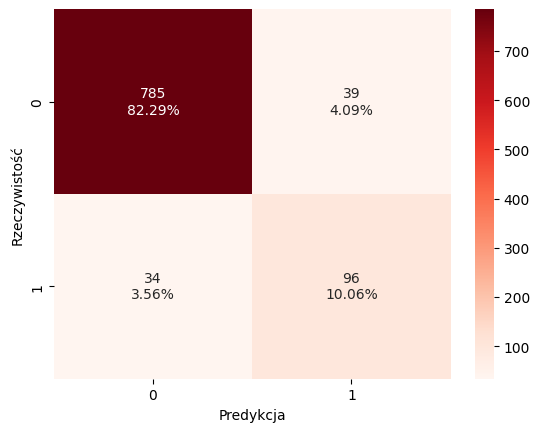

In [24]:
summary_model(LDA_202307_default, X_202307_train, y_202307_train, ['0','1'])

In [25]:
show_metrics(LDA_202307_default, X_202307_train, y_202307_train)

Dokładność (accuracy): 92.35%
Precyzja (precision): 71.11%
Czułość (recall): 73.85%
F1-score: 72.45%


### Ocena na zbiorze testowym

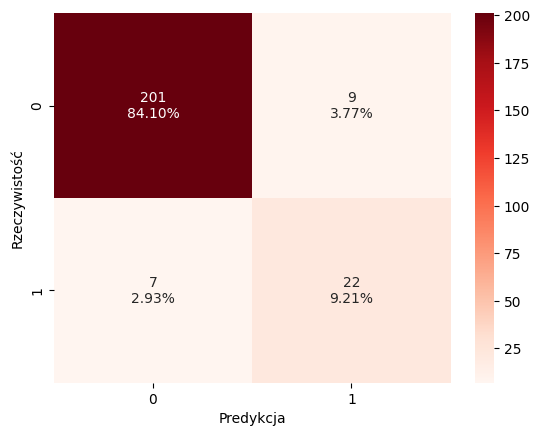

In [26]:
summary_model(LDA_202307_default, X_202307_test, y_202307_test, ['0', '1'])

In [27]:
show_metrics(LDA_202307_default, X_202307_test, y_202307_test)

Dokładność (accuracy): 93.31%
Precyzja (precision): 70.97%
Czułość (recall): 75.86%
F1-score: 73.33%


### Obserwacje

Model zarówno na zbiorze treningowym, jak i testowym wypada całkiem dobrze. Otrzymujemy na zbiorze testowym accuracy wynoszące 93.31%. Precyzja w przypadku zbioru testowego odrobinę się zmniejszyła (o ok. 0.14 p. p.), natomiast wartości pozostałych metryk są wyższe niż dla zbioru treningowego.

# GridSearch

Spróbujmy wykorzystując GridSearch'a znaleźć parametry, dla których model powinien dawać najlepsze wyniki.

In [32]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': ['auto', None],
    'store_covariance': [True, False],
    'tol': [1e-4, 1e-5, 1e-6]
}

In [33]:
lda = LinearDiscriminantAnalysis()

grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_202307_train, y_202307_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'shrinkage': ['auto', None],
                         'solver': ['svd', 'lsqr', 'eigen'],
                         'store_covariance': [True, False],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='accuracy')

In [34]:
print("Najlepsze parametry:", grid_search.best_params_)

Najlepsze parametry: {'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.0001}


In [35]:
gridsearch_LDA_model = grid_search.best_estimator_
gridsearch_LDA_model.fit(X_202307_train, y_202307_train)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr',
                           store_covariance=True)

Zastosujmy model na pełnych danych:

In [38]:
LDA_202307_gridsearch_model_pred_FULL = NASA_202307.copy()
LDA_202307_gridsearch_model_pred_FULL['pustynia'] = gridsearch_LDA_model.predict(LDA_202307_gridsearch_model_pred_FULL.loc[:,'Rainf':'SoilM_100_200cm'])

In [39]:
output_notebook()
show(plot_map(df=LDA_202307_gridsearch_model_pred_FULL, parameter_name='pustynia',
              colormap=dict(zip(['1', '0'], ['yellow', 'green'])),
              title='Pustynie (1) i niepustynie (0) - LDA (lipiec 2023, parametry znalezione przez GridSearch)',
              point_size=6, alpha=0.7))

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


### Ocena modelu na zbiorze treningowym

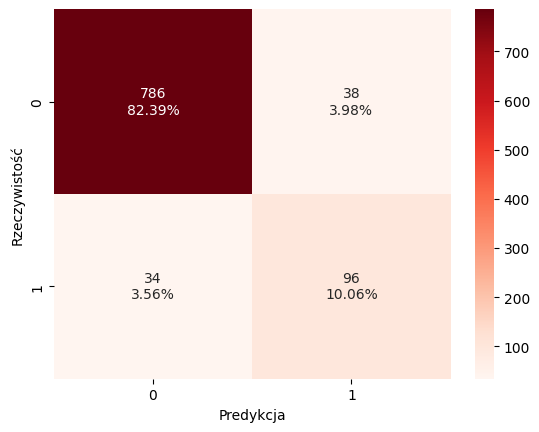

In [40]:
summary_model(gridsearch_LDA_model, X_202307_train, y_202307_train, ['0','1'])

In [41]:
show_metrics(gridsearch_LDA_model, X_202307_train, y_202307_train)

Dokładność (accuracy): 92.45%
Precyzja (precision): 71.64%
Czułość (recall): 73.85%
F1-score: 72.73%


### Ocena modelu na zbiorze testowym

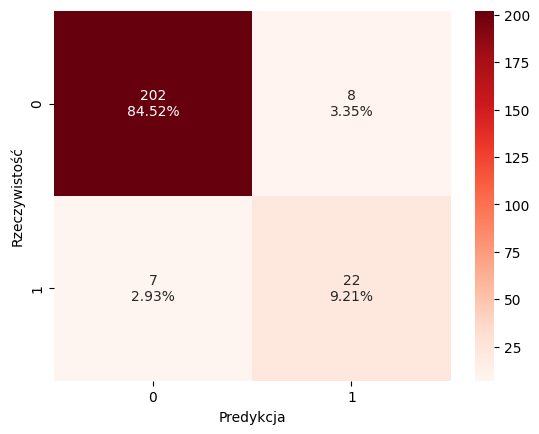

In [42]:
summary_model(gridsearch_LDA_model, X_202307_test, y_202307_test, ['0', '1'])

In [43]:
show_metrics(gridsearch_LDA_model, X_202307_test, y_202307_test)

Dokładność (accuracy): 93.72%
Precyzja (precision): 73.33%
Czułość (recall): 75.86%
F1-score: 74.58%


### Obserwacje

Dla obu zbiorów otrzymaliśmy lepsze wyniki niż w przypadku modelu z domyślnymi parametrami. Jedynie czułość pozostała niezmieniona. Ponadto, teraz wartość każdej z metryk dla zbioru testowego jest wyższa niż dla zbioru treningowego. Accuracy na zbiorze testowym wyniosło 93.72%.

## Zbalansowanie zbioru danych

Spróbujmy jeszcze zbalansować klasy w zbiorze danych.

In [45]:
X_202307_resampled, y_202307_resampled = SMOTE().fit_resample(X_202307_train, y_202307_train)

In [47]:
grid_search_resampled = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')
grid_search_resampled.fit(X_202307_resampled, y_202307_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'shrinkage': ['auto', None],
                         'solver': ['svd', 'lsqr', 'eigen'],
                         'store_covariance': [True, False],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='accuracy')

In [48]:
print("Najlepsze parametry:", grid_search_resampled.best_params_)

Najlepsze parametry: {'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}


Tym razem zmienił się solver, a shrinkage z 'auto' zmieniło się na 'None'.

### Ocena modelu na zbiorze treningowym

In [49]:
gridsearch_LDA_model_resampled = grid_search_resampled.best_estimator_
gridsearch_LDA_model_resampled.fit(X_202307_resampled, y_202307_resampled)

LinearDiscriminantAnalysis(store_covariance=True)

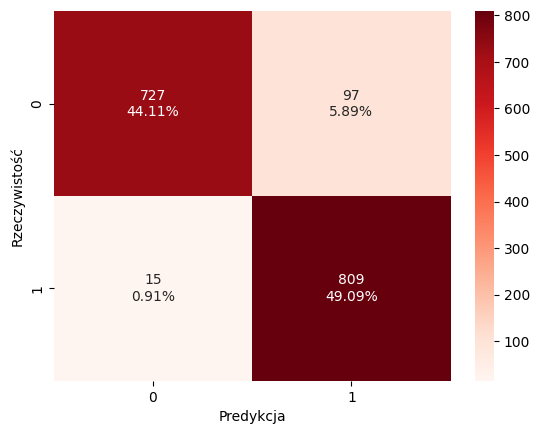

In [50]:
summary_model(gridsearch_LDA_model_resampled, X_202307_resampled, y_202307_resampled, ['0','1'])

In [51]:
show_metrics(gridsearch_LDA_model_resampled, X_202307_resampled, y_202307_resampled)

Dokładność (accuracy): 93.20%
Precyzja (precision): 89.29%
Czułość (recall): 98.18%
F1-score: 93.53%


### Ocena modelu na zbiorze testowym

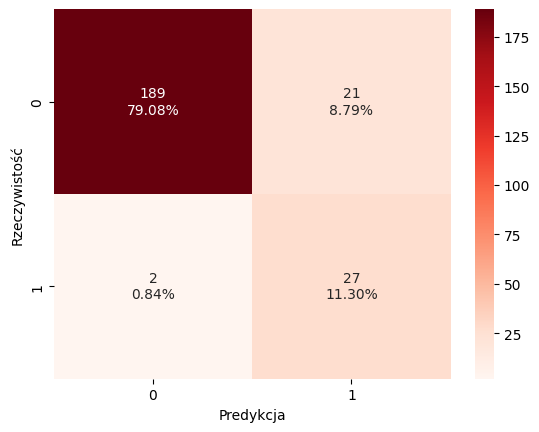

In [52]:
summary_model(gridsearch_LDA_model_resampled, X_202307_test, y_202307_test, ['0', '1'])

In [53]:
show_metrics(gridsearch_LDA_model_resampled, X_202307_test, y_202307_test)

Dokładność (accuracy): 90.38%
Precyzja (precision): 56.25%
Czułość (recall): 93.10%
F1-score: 70.13%


### Obserwacje

Niestety tym razem, mimo bardzo obiecujących wyników dla zbioru treningowego, dla zbioru testowego znacząco zmniejszyła się precyzja (o 33 p. p. względem zbioru treningowego, o 17 p. p. w porównaniu do modelu niezbalansowanego). Jedynie czułość jest lepsza o ok. 20 p. p. niż we wcześniejszych przypadkach.

## Końcowy wniosek

W przypadku modelu LDA, jak również części innych stworzonych dla danych NASA modeli, zbalansowanie zbioru danych nie poprawia końcowych wyników. Najlepszy z modeli LDA osiągnął na zbiorze testowym accuracy równe 93.72%, co jest bardzo dobrym wynikiem, jednakże niższym niż w przypadku najlepszego z powstałych w czasie trwania projektu modeli.